# Content-Based Recommendation Engine

Anaysis by Brendan Bullivant & Frank Flavell

## Overview

The content-based system takes in the name of a movie that the user likes and outputs a list of 10 similar movies.  The similarity is determined by calculating the cosine similarity between cleaned text descriptions of each movie after being vectorized using the TF-IDF Vectorizer.  Unlike SVD, there aren't specific metrics that can be used to evaluate the effecitveness of the system's recommendations.  However, based on our own and our friends' testing phase, the content-based system performed very well at identifying similar movies to our favorites, without being limited by a movie's rating.  In practice, this system solves some of the issues of the SVDpp model in that it can actually guide a person to a similar movie within the dataset, even if it isn't in the Sleeping Giant subset.  This approach allows Disney plus to take even more advantge of the other movies in their existing IP and increase the quantity of content on the platform.


## Table of Contents<span id="0"></span>

1. [**Data & Clean Data**](#1)
    * Clean and merge necessary datasets.
    <br/><br/>
2. [**Exploratory Data Analysis**](#2)
    * Determine movie description length
    * Identify the most frequent words
    * Remove stop words
    * Extract genres and include in descriptions
    <br/><br/>
3. [**Building the Recommendation System**](#3)
    * Reset df index with movie titles
    * TF-IDF Vectorizer
    * Calculate Cosine Similarity Matrix
    * Test the system
    <br/><br/>

# Package Import

In [217]:
# import external libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
import re #regex
import random
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

! pip install surprise
from surprise import Dataset, Reader
from surprise import SVD
from surprise import accuracy
from surprise.model_selection import cross_validate, train_test_split

# Configure matplotlib for jupyter.
%matplotlib inline

     |████████████████████████████████| 6.5MB 1.0MB/s eta 0:00:01
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.0-cp37-cp37m-macosx_10_9_x86_64.whl size=833376 sha256=e2a1cb13a51bf983af5b914b88bc103c00e62397d48667a04f1445b24010ad5d
  Stored in directory: /Users/matthewflavell/Library/Caches/pip/wheels/cc/fa/8c/16c93fccce688ae1bde7d979ff102f7bee980d9cfeb8641bcf
Successfully built scikit-surprise


# <span id="1"></span>1. Data Import & API Calls
#### [Return Contents](#0)

We import the .csv files listed in the dataset summary above and review their contents.  We decided to merge the movies and the ratings together.  Since we do not need additional information to build a recommendaiton system, we do not need the links .csv for making api calls to IMDB and TMDB.  We also do not need the tags at this time.

In [344]:
#Imports the dataframes
links = pd.read_csv("ml-latest-small/links.csv")
tags = pd.read_csv("ml-latest-small/tags.csv")
df = pd.read_pickle('cleaned.pickle')
tmdb = pd.read_pickle('raw_tmdb.pickle')

# Clean Links DataFrame

In [345]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [346]:
links.shape

(9742, 3)

In [347]:
links.dropna(inplace=True)

In [348]:
links.shape

(9734, 3)

In [349]:
links['tmdbId'] = links['tmdbId'].astype(int)

# Tags DataFrame

We have descriptions for over 9,600 movies, but there are tags for only 3,683 of them.  It might not be useful to extract and combine these tags into a new text feature if we are missing tags for over half the movies.

In [350]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [351]:
tags.shape

(3683, 4)

In [352]:
tags.groupby('movieId').count()

,userId,tag,timestamp
movieId,,,
1,3,3,3
2,4,4,4
3,2,2,2
5,2,2,2
7,1,1,1
...,...,...,...
183611,3,3,3
184471,3,3,3
187593,3,3,3


## MovieLens DataFrame

In [353]:
lens = pd.read_pickle('cleaned.pickle')

In [354]:
lens[lens['movieId'] == 2]

,userId,movieId,rating,title,genres,year
27150,6,2,4.0,Jumanji (1995),Adventure|Children|Fantasy,1995
27151,8,2,4.0,Jumanji (1995),Adventure|Children|Fantasy,1995
27152,18,2,3.0,Jumanji (1995),Adventure|Children|Fantasy,1995
27153,19,2,3.0,Jumanji (1995),Adventure|Children|Fantasy,1995
27154,20,2,3.0,Jumanji (1995),Adventure|Children|Fantasy,1995
...,...,...,...,...,...,...
27255,600,2,4.0,Jumanji (1995),Adventure|Children|Fantasy,1995
27256,602,2,4.0,Jumanji (1995),Adventure|Children|Fantasy,1995
27257,604,2,5.0,Jumanji (1995),Adventure|Children|Fantasy,1995
27258,605,2,3.5,Jumanji (1995),Adventure|Children|Fantasy,1995


In [355]:
lens.columns

Index(['userId', 'movieId', 'rating', 'title', 'genres', 'year'], dtype='object')

In [356]:
lens_deets = lens[['movieId', 'title', 'genres']]

In [357]:
lens_deets.drop_duplicates(inplace=True)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [358]:
lens_deets[lens_deets['movieId'] == 2]

,movieId,title,genres
27150,2,Jumanji (1995),Adventure|Children|Fantasy


# TMDB DataFrame

In [399]:
tmdb[tmdb['original_title'] == "Child's Play 2"]

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,tmdbId,imdb_id,original_language,original_title,...,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,status_code,status_message
1465,False,/zkz2kgGAqwwiqLnpfhTNEjAjPa1.jpg,"{'id': 10455, 'name': 'Child's Play Collection...",13000000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 27, 'name...",,11186.0,tt0099253,en,Child's Play 2,...,84.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Look out Jack! Chucky's back!,Child's Play 2,False,6.0,858.0,NaN,NaN


In [359]:
tmdb.head()

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,...,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,status_code,status_message
0,False,/lxD5ak7BOoinRNehOCA85CQ8ubr.jpg,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862.0,tt0114709,en,Toy Story,...,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,,Toy Story,False,7.9,12235.0,NaN,NaN
1,False,/y7SQmjlB42VvYyRIFQXLQ4ZYrn.jpg,"{'id': 495527, 'name': 'Jumanji Collection', '...",65000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",http://www.sonypictures.com/movies/jumanji/,8844.0,tt0113497,en,Jumanji,...,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,7.2,7169.0,NaN,NaN
2,False,/vAZZrfi0xwE226zpSTAbJ7gUWwf.jpg,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",,15602.0,tt0113228,en,Grumpier Old Men,...,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.6,191.0,NaN,NaN
3,False,None,None,16000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",,31357.0,tt0114885,en,Waiting to Exhale,...,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.3,71.0,NaN,NaN
4,False,/wKQlgHjJwh5mGBZ37vDsXBx9zbh.jpg,"{'id': 96871, 'name': 'Father of the Bride Col...",0.0,"[{'id': 35, 'name': 'Comedy'}]",,11862.0,tt0113041,en,Father of the Bride Part II,...,106.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,6.1,397.0,NaN,NaN


In [396]:
tmdb.columns

Index(['adult', 'backdrop_path', 'belongs_to_collection', 'budget', 'genres',
       'homepage', 'tmdbId', 'imdb_id', 'original_language', 'original_title',
       'overview', 'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count', 'status_code', 'status_message'],
      dtype='object')

In [360]:
tmdb.shape

(9733, 27)

In [361]:
tmdb = tmdb.rename(columns={'id' : 'tmdbId'})

In [362]:
tmdb['tmdbId'].dropna(inplace=True)

## Isolate and Merge TMDB Descriptions with Links DataFrame

We weren't able to get a description for 104 of the movies, so our list is slightly smaller than before.

In [363]:
tmbd_desc = tmdb[['tmdbId', 'overview']]

In [364]:
tmbd_desc

,tmdbId,overview
0,862.0,"Led by Woody, Andy's toys live happily in his ..."
1,8844.0,When siblings Judy and Peter discover an encha...
2,15602.0,A family wedding reignites the ancient feud be...
3,31357.0,"Cheated on, mistreated and stepped on, the wom..."
4,11862.0,Just when George Banks has recovered from his ...
...,...,...
9728,360617.0,Celebrating Jon Stewart's decade and a half ru...
9729,432131.0,"Ciel learns of a ""Aurora Society"", that is rum..."
9730,445030.0,"In ancient Disboard, Riku is an angry, young w..."
9731,479308.0,A woman deals with the toxic water scandal in ...


In [365]:
links = pd.merge(links, tmbd_desc, on="tmdbId")

In [366]:
df = links

In [367]:
df

,movieId,imdbId,tmdbId,overview
0,1,114709,862,"Led by Woody, Andy's toys live happily in his ..."
1,2,113497,8844,When siblings Judy and Peter discover an encha...
2,3,113228,15602,A family wedding reignites the ancient feud be...
3,4,114885,31357,"Cheated on, mistreated and stepped on, the wom..."
4,5,113041,11862,Just when George Banks has recovered from his ...
...,...,...,...,...
9627,193579,5342766,360617,Celebrating Jon Stewart's decade and a half ru...
9628,193581,5476944,432131,"Ciel learns of a ""Aurora Society"", that is rum..."
9629,193583,5914996,445030,"In ancient Disboard, Riku is an angry, young w..."
9630,193585,6397426,479308,A woman deals with the toxic water scandal in ...


In [368]:
df = df.rename(columns={'overview' : 'desc'})

# <span id="2"></span>2. Exploratory Data Analysis
#### [Return Contents](#0)

### Determine description length for each movie & average length

* There are 9632.0 descriptions in total.
* The longest description has 178.0 words.
* The shortest description has 1.0 word.
* The average word count is 50.5 words per description.

In [369]:
# count the common length of description
df['desc_leng'] = df.desc.apply(lambda x: len(x.split(" ")))

In [370]:
df.head(2)

,movieId,imdbId,tmdbId,desc,desc_leng
0,1,114709,862,"Led by Woody, Andy's toys live happily in his ...",50
1,2,113497,8844,When siblings Judy and Peter discover an encha...,67


In [371]:
df.desc_leng.describe()

print("There are {} documents in total".format(df.desc_leng.describe()['count']))
print("The longest document has {} words".format(df.desc_leng.describe()['max']))
print("The shortest document has {} words".format(df.desc_leng.describe()['min']))
print("The average word count is {} words per document".format(round(df.desc_leng.describe()['mean'], 1)))

There are 9632.0 documents in total
The longest document has 178.0 words
The shortest document has 1.0 words
The average word count is 50.5 words per document


Text(0, 0.5, 'Number of descriptions')

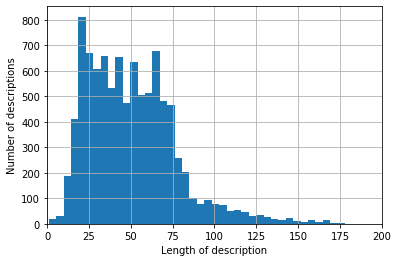

In [402]:
# examining the distribution of the description lengths
df.desc_leng.hist(bins = 40)
plt.xlim([0, 200])
plt.xlabel('Length of description')
plt.ylabel('Number of descriptions')

## Identify The Most Frequent Words

There are a lot of stop words in the list of most frequent words in thedescriptions.  We will need to remove the stop words to get closer to isolating the most relevant keywords in the descriptions.

In [373]:
# getting the word frequency of the description
word_freq = df.desc.str.split(expand=True).stack().value_counts()

In [374]:
word_freq[:20]

the      24394
a        18285
to       15537
and      14222
of       13402
in        7995
his       7792
is        6588
with      4584
her       3602
he        3539
for       3528
on        3234
an        3215
that      3016
their     2863
by        2841
who       2676
as        2499
from      2391
dtype: int64

<BarContainer object of 20 artists>

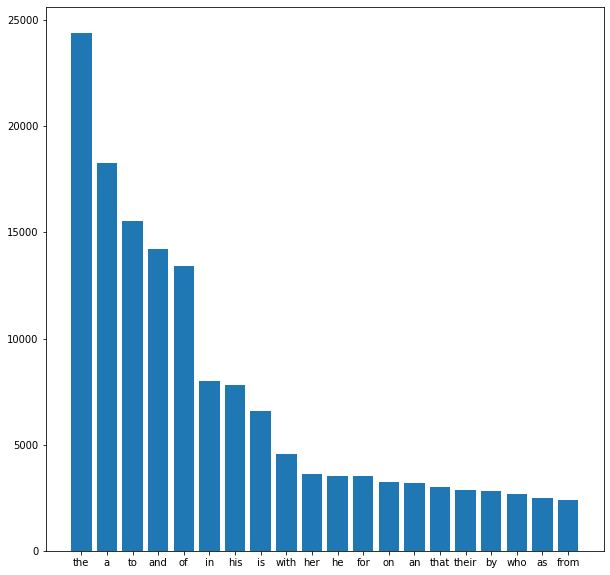

In [375]:
word_freq_top_20 = word_freq[:20]
word_freq_top_20 = dict(word_freq_top_20)
plt.figure(figsize=(10,10))
plt.bar(range(len(word_freq_top_20)), word_freq_top_20.values(), tick_label=list(word_freq_top_20.keys()))

## Remove Stop Words and Compare Descriptions

After removing stop words, the descriptions are closer to containing only the key words that are most relevant for each movie.

In [376]:
# first of all, let us remove some useless words to see how our documents change
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
stop_words = set(stopwords.words('english')) 

In [377]:
df['desc_cleaned'] = df.desc.apply(lambda x:x.lower())
df['without_stopwords'] = df['desc_cleaned'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
df.head()

,movieId,imdbId,tmdbId,desc,desc_leng,desc_cleaned,without_stopwords
0,1,114709,862,"Led by Woody, Andy's toys live happily in his ...",50,"led by woody, andy's toys live happily in his ...","led woody, andy's toys live happily room andy'..."
1,2,113497,8844,When siblings Judy and Peter discover an encha...,67,when siblings judy and peter discover an encha...,siblings judy peter discover enchanted board g...
2,3,113228,15602,A family wedding reignites the ancient feud be...,56,a family wedding reignites the ancient feud be...,family wedding reignites ancient feud next-doo...
3,4,114885,31357,"Cheated on, mistreated and stepped on, the wom...",45,"cheated on, mistreated and stepped on, the wom...","cheated on, mistreated stepped on, women holdi..."
4,5,113041,11862,Just when George Banks has recovered from his ...,59,just when george banks has recovered from his ...,"george banks recovered daughter's wedding, rec..."


In [378]:
# comparing description with stopwords and description without stopwords
print(df.without_stopwords[0])
print('------------------------')
print(df.desc[0])

led woody, andy's toys live happily room andy's birthday brings buzz lightyear onto scene. afraid losing place andy's heart, woody plots buzz. circumstances separate buzz woody owner, duo eventually learns put aside differences.
------------------------
Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences.


In [379]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
    
df['desc_cleaned'] = df['desc'].apply(clean_text)

# Extract Genre Names and Include in the Description

After testing the model based on the cleaned descriptions, we decided to improve the model's performance by extracting the genres from each movie and including those genre names in the movie description.  This did improve the results slightly.

In [380]:
df = pd.merge(df, lens_deets, on='movieId')

In [381]:
df.head()

,movieId,imdbId,tmdbId,desc,desc_leng,desc_cleaned,without_stopwords,title,genres
0,1,114709,862,"Led by Woody, Andy's toys live happily in his ...",50,led woody andys toys live happily room andys b...,"led woody, andy's toys live happily room andy'...",Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,113497,8844,When siblings Judy and Peter discover an encha...,67,siblings judy peter discover enchanted board g...,siblings judy peter discover enchanted board g...,Jumanji (1995),Adventure|Children|Fantasy
2,3,113228,15602,A family wedding reignites the ancient feud be...,56,family wedding reignites ancient feud nextdoor...,family wedding reignites ancient feud next-doo...,Grumpier Old Men (1995),Comedy|Romance
3,4,114885,31357,"Cheated on, mistreated and stepped on, the wom...",45,cheated mistreated stepped women holding breat...,"cheated on, mistreated stepped on, women holdi...",Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,113041,11862,Just when George Banks has recovered from his ...,59,george banks recovered daughters wedding recei...,"george banks recovered daughter's wedding, rec...",Father of the Bride Part II (1995),Comedy


In [382]:
df['genres'] = df['genres'].apply(clean_text)

In [383]:
df['desc_cleaned'] = df['desc_cleaned'] + " | " + df['genres']

In [384]:
# compare the cleaned version of description
df['desc_cleaned'][0]

'led woody andys toys live happily room andys birthday brings buzz lightyear onto scene afraid losing place andys heart woody plots buzz circumstances separate buzz woody owner duo eventually learns put aside differences | adventure animation children comedy fantasy'

In [385]:
df['desc_cleaned'] = df['desc_cleaned'].apply(clean_text)

In [386]:
df['desc_cleaned'][0]

'led woody andys toys live happily room andys birthday brings buzz lightyear onto scene afraid losing place andys heart woody plots buzz circumstances separate buzz woody owner duo eventually learns put aside differences adventure animation children comedy fantasy'

<BarContainer object of 20 artists>

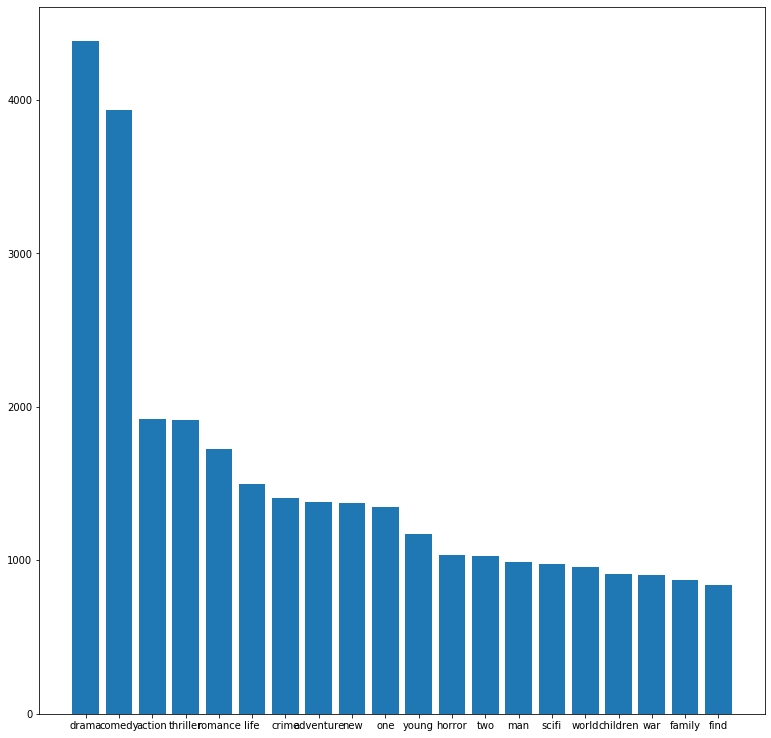

In [387]:
word_freq_clean = df.desc_cleaned.str.split(expand=True).stack().value_counts()
word_freq_clean[:20]
plt.figure(figsize=(13,13))
plt.bar(range(len(word_freq_clean[:20])), dict(word_freq_clean[:20]).values(), tick_label=list(dict(word_freq_clean[:20]).keys()))

# <span id="3"></span>3. Building Recommendation Engine
#### [Return Contents](#0)

In [388]:
df.set_index('title', inplace = True)

In [400]:
df['desc_cleaned'][0]

'led woody andys toys live happily room andys birthday brings buzz lightyear onto scene afraid losing place andys heart woody plots buzz circumstances separate buzz woody owner duo eventually learns put aside differences adventure animation children comedy fantasy'

We calculated the cosine similarity between descriptions by using the TF-IDF Vectorizer.

In [389]:
# calculate cosine similarity between documents - we use tfidf
from sklearn.metrics.pairwise import cosine_similarity
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(df['desc_cleaned'])
similarity_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)
print(cosine_similarity(tfidf_matrix, tfidf_matrix))

[[1.00000000e+00 8.39456921e-03 4.75486529e-04 ... 3.98869606e-03
  0.00000000e+00 6.80819529e-03]
 [8.39456921e-03 1.00000000e+00 5.52109710e-03 ... 4.94571179e-03
  0.00000000e+00 1.53948610e-03]
 [4.75486529e-04 5.52109710e-03 1.00000000e+00 ... 2.91077410e-03
  3.34296242e-03 0.00000000e+00]
 ...
 [3.98869606e-03 4.94571179e-03 2.91077410e-03 ... 1.00000000e+00
  0.00000000e+00 5.62537299e-03]
 [0.00000000e+00 0.00000000e+00 3.34296242e-03 ... 0.00000000e+00
  1.00000000e+00 0.00000000e+00]
 [6.80819529e-03 1.53948610e-03 0.00000000e+00 ... 5.62537299e-03
  0.00000000e+00 1.00000000e+00]]


We saved the cosine similarity matrix for use in other hybrid systems.

In [401]:
import pickle
filename = 'cosine_sim_matrix.pickle'
pickle.dump(similarity_matrix, open(filename, 'wb'))

In [390]:
indices = pd.Series(df.index)

In [391]:
def recommendations(name, similarity_matrix = similarity_matrix):
    
    recommended_movies = []
    
    # getting the index of the movie that matches the name
    idx = indices[indices == name].index[0]

    # creating a Series with the similarity scores in descending order
    score_series = pd.Series(similarity_matrix[idx]).sort_values(ascending = False)

    # getting the indexes of the 10 most similar movies except itself
    top_10_indexes = list(score_series.iloc[1:11].index)
    
    #Cross reference top n indexes with sleeping giants (and/or giants)
    
    # populating the list with the names of the top 10 matching movies
    for i in top_10_indexes:
        recommended_movies.append(list(df.index)[i])
        
    return recommended_movies

In [392]:
# get the list of optional names 
df.index

Index(['Toy Story (1995)', 'Jumanji (1995)', 'Grumpier Old Men (1995)',
       'Waiting to Exhale (1995)', 'Father of the Bride Part II (1995)',
       'Heat (1995)', 'Sabrina (1995)', 'Tom and Huck (1995)',
       'Sudden Death (1995)', 'GoldenEye (1995)',
       ...
       'Gintama (2017)', 'Gintama: The Movie (2010)',
       'anohana: The Flower We Saw That Day - The Movie (2013)',
       'Silver Spoon (2014)', 'Love Live! The School Idol Movie (2015)',
       'Jon Stewart Has Left the Building (2015)',
       'Black Butler: Book of the Atlantic (2017)',
       'No Game No Life: Zero (2017)', 'Flint (2017)',
       'Bungo Stray Dogs: Dead Apple (2018)'],
      dtype='object', name='title', length=9584)

## Model Testing

Input your favorite movie from the list of almost 10,000 films and get a list of the 10 most similar movies based on their descriptions.

In [397]:
recomendations = input("what types of movies would you like me to recommend for ya?")
recommendations(recomendations)

what types of movies would you like me to recommend for ya?Toy Story (1995)


['Toy Story 2 (1999)',
 'Toy Story 3 (2010)',
 "Child's Play 2 (1990)",
 'Wild, The (2006)',
 'Turbo (2013)',
 'Monsters, Inc. (2001)',
 'The Good Dinosaur (2015)',
 'Malice (1993)',
 'Rebel Without a Cause (1955)',
 'Condorman (1981)']

We can improve this system by including conditional statements in the recommendation function to filter out inapproproate or unrelated recommendations based on their genre, release year, and suitability rating.